# Music Genre Classification Using Audio Feature Extraction and Machine-Learning Models

**Course:** CAP 4630-001-042 - Introduction to Artificial Intelligence  
**Instructor:** Dr. Ahmed Imteaj  
**Student:** Andres Hernandez  
**Date:** Fall 2025

---

## Project Description

This project implements a supervised machine learning system for classifying audio tracks into musical genres using Mel-Frequency Cepstral Coefficients (MFCCs) as the primary feature representation. The system extracts audio features from raw audio files, processes them into fixed-length vectors, and trains multiple classification models to predict genre labels.

## Deliverables

1. Complete audio feature extraction pipeline using librosa
2. Implementation of multiple baseline classifiers (KNN, Decision Trees, Random Forest, SVM)
3. Hyperparameter tuning and model optimization
4. Comprehensive evaluation with confusion matrices and performance metrics
5. Analysis of results, challenges, and future improvements

---

## 1. Objective

### Task Definition
Classify audio tracks into musical genres using MFCC-based audio features and supervised machine learning classifiers.

### Target Outcome
Develop a trained classification model with measurable performance metrics (accuracy, precision, recall, F1-score) that can accurately predict the genre of previously unseen audio tracks.

### Success Criteria
- Achieve baseline accuracy above random guessing (>10% for 10 genres)
- Compare multiple classification algorithms
- Identify optimal hyperparameters through systematic tuning
- Document model performance with comprehensive evaluation metrics

---

## 2. Background

### Why Music Genre Classification?

Music genre classification is a fundamental task in Music Information Retrieval (MIR) with practical applications in:
- **Music streaming services**: Automated playlist generation and recommendation systems
- **Music libraries**: Organizing and categorizing large audio collections
- **Music production**: Assisting composers and producers in understanding musical patterns
- **Academic research**: Understanding the structural and timbral characteristics that define genres

### Mel-Frequency Cepstral Coefficients (MFCCs)

MFCCs are the standard audio feature representation for speech and music analysis because they:
- Model the human auditory system's perception of sound
- Capture the spectral envelope of audio signals
- Provide compact, fixed-length representations regardless of audio duration
- Effectively represent timbral texture, which is crucial for genre differentiation

**Technical Process:**
1. Convert time-domain audio to frequency domain via Short-Time Fourier Transform (STFT)
2. Apply mel-scale filterbank to match human perception
3. Take logarithm of filterbank energies
4. Apply Discrete Cosine Transform (DCT) to decorrelate features
5. Extract lower-order coefficients (typically 13-40) as features

### Classification Algorithms

For structured numeric features like MFCCs, several supervised classifiers are suitable:
- **K-Nearest Neighbors (KNN)**: Instance-based learning, effective for multi-class problems
- **Decision Trees**: Interpretable, handles non-linear decision boundaries
- **Random Forest**: Ensemble method, reduces overfitting through averaging
- **Support Vector Machines (SVM)**: Effective in high-dimensional spaces with clear margins

---

## 3. Setup and Imports

Import all necessary libraries for audio processing, machine learning, and visualization.

In [ ]:
# Standard libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path

# Audio processing
import librosa
import librosa.display

# Machine learning
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    confusion_matrix,
    classification_report
)

# Settings
warnings.filterwarnings('ignore')
np.random.seed(42)
# plt.style.use('seaborn-v0_8')  # Commented out - can cause hanging
plt.rcParams['figure.figsize'] = (12, 6)

print("All libraries imported successfully!")

---

## Quick Start Guide

**To run this notebook:**

1. **Run the imports cell above** ☝️ to load all libraries
2. **Run the dataset configuration cell below** 👇 to verify GTZAN path
3. **Execute cells sequentially** - each section builds on the previous one
4. **Feature extraction takes 10-20 minutes** - be patient!
5. **Watch for progress indicators** in the output

**Current Dataset Path:** `/Users/andres/Documents/University/FALL 2025 /CAP4630/Dataset/GTZAN/genres_original`

✅ Dataset is already configured and ready to use!

---

## 4. Dataset Description

### Dataset Source
**GTZAN Genre Collection** (or specify your actual dataset)

### Dataset Specifications
- **Number of samples**: 1000 audio files (100 per genre)
- **Genres**: 10 classes (blues, classical, country, disco, hiphop, jazz, metal, pop, reggae, rock)
- **File format**: .wav or .mp3
- **Duration**: 30 seconds per track
- **Sampling rate**: 22,050 Hz (standard for music analysis)
- **Class balance**: Balanced dataset with equal samples per genre

### Preprocessing Requirements
- Handle corrupted or unreadable audio files
- Normalize audio length to consistent duration
- Convert stereo to mono if necessary
- Resample to target sampling rate if needed

In [ ]:
# Dataset configuration
DATASET_PATH = "/Users/andres/Documents/University/FALL 2025 /CAP4630/Dataset/GTZAN/genres_original"
SAMPLING_RATE = 22050
DURATION = 30  # seconds
N_MFCC = 13  # Number of MFCC coefficients to extract

# Check if dataset path exists
if os.path.exists(DATASET_PATH):
    print(f"✓ Dataset found at: {DATASET_PATH}")
    
    # Count files per genre
    genres = sorted([d for d in os.listdir(DATASET_PATH) if os.path.isdir(os.path.join(DATASET_PATH, d))])
    print(f"\nGenres found: {len(genres)}")
    for genre in genres:
        genre_path = os.path.join(DATASET_PATH, genre)
        wav_files = [f for f in os.listdir(genre_path) if f.endswith('.wav')]
        print(f"  {genre}: {len(wav_files)} files")
else:
    print(f"⚠️ Dataset path not found. Please update DATASET_PATH variable.")
    print(f"Current path: {DATASET_PATH}")

✓ Dataset found at: /Users/andres/Documents/University/FALL 2025 /CAP4630/Dataset/GTZAN/genres_original

Genres found: 10
  blues: 100 files
  classical: 100 files
  country: 100 files
  disco: 100 files
  hiphop: 100 files
  jazz: 100 files
  metal: 100 files
  pop: 100 files
  reggae: 100 files
  rock: 100 files


---

## 5. Methodology

### Complete Pipeline (Sequential Steps)

1. **Load audio**: Read audio files at fixed sampling rate (22,050 Hz)
2. **Extract MFCCs**: Compute MFCC features with fixed parameters (n_mfcc=13)
3. **Aggregate features**: Convert variable-length MFCC matrices into fixed-length vectors using mean/std
4. **Build feature matrix**: Combine all feature vectors and labels into structured arrays
5. **Split dataset**: Divide into training (80%) and test (20%) sets with stratification
6. **Train baseline models**: Fit KNN, Decision Tree, Random Forest, and SVM classifiers
7. **Hyperparameter tuning**: Use GridSearchCV to optimize model parameters
8. **Evaluate models**: Compute accuracy, precision, recall, F1-score, and confusion matrices

### Technical Constraints
- Fixed MFCC vector dimension: 26 features (13 mean + 13 std coefficients)
- Consistent sampling rate across all audio files
- Stratified splitting to maintain class balance

---

## 6. System Design

### Pipeline Architecture

```
┌─────────────┐      ┌──────────────────┐      ┌────────────────────┐
│ Input Audio │ ───> │ Feature          │ ───> │ Feature            │
│ (.wav/.mp3) │      │ Extraction       │      │ Aggregation        │
│             │      │ (MFCC)           │      │ (Mean + Std)       │
└─────────────┘      └──────────────────┘      └────────────────────┘
                              │                          │
                              ▼                          ▼
                     22050 Hz audio          [n_samples × 26] matrix
                     13 MFCC coefficients    (13 mean + 13 std)
                              │                          │
                              └──────────┬───────────────┘
                                         ▼
                              ┌────────────────────┐
                              │ Train/Test Split   │
                              │ (80/20)            │
                              └────────────────────┘
                                         │
                              ┌──────────┴──────────┐
                              ▼                     ▼
                     ┌──────────────┐      ┌──────────────┐
                     │ Model        │      │ Model        │
                     │ Training     │      │ Evaluation   │
                     └──────────────┘      └──────────────┘
                              │                     │
                              ▼                     ▼
                     ┌──────────────┐      ┌──────────────┐
                     │ Trained      │      │ Performance  │
                     │ Classifier   │      │ Metrics      │
                     └──────────────┘      └──────────────┘
                              │                     │
                              └──────────┬──────────┘
                                         ▼
                              ┌────────────────────┐
                              │ Genre Prediction   │
                              └────────────────────┘
```

---

## 7. Implementation

### Part A: Data Loading and Audio Preprocessing

Load audio files from the dataset directory, handle corrupted files, and organize data by genre labels.

In [ ]:
def load_audio_files(dataset_path):
    """
    Load audio files from dataset directory and extract genre labels.
    
    Parameters:
    -----------
    dataset_path : str
        Path to the dataset root directory
        
    Returns:
    --------
    audio_data : list
        List of tuples (file_path, genre_label)
    """
    audio_data = []
    corrupted_files = []
    
    # Assuming dataset structure: dataset_path/genre/audio_files
    if not os.path.exists(dataset_path):
        print(f"Dataset path does not exist: {dataset_path}")
        return audio_data, corrupted_files
    
    # Iterate through genre folders
    for genre in os.listdir(dataset_path):
        genre_path = os.path.join(dataset_path, genre)
        
        # Skip if not a directory
        if not os.path.isdir(genre_path):
            continue
            
        print(f"Loading {genre} files...")
        
        # Iterate through audio files in genre folder
        for filename in os.listdir(genre_path):
            file_path = os.path.join(genre_path, filename)
            
            # Check if it's an audio file
            if filename.endswith(('.wav', '.mp3', '.au')):
                try:
                    # Test loading the file
                    y, sr = librosa.load(file_path, sr=SAMPLING_RATE, duration=DURATION)
                    audio_data.append((file_path, genre))
                except Exception as e:
                    corrupted_files.append((file_path, str(e)))
                    print(f"  ⚠️ Corrupted file: {filename}")
    
    print(f"\nSuccessfully loaded {len(audio_data)} audio files")
    print(f"Corrupted files: {len(corrupted_files)}")
    
    return audio_data, corrupted_files

# Load dataset
print("="*70)
print("LOADING GTZAN DATASET")
print("="*70)
audio_files, corrupted = load_audio_files(DATASET_PATH)

LOADING GTZAN DATASET
Loading pop files...
Loading metal files...
Loading metal files...
Loading disco files...
Loading disco files...
Loading blues files...
Loading blues files...
Loading reggae files...
Loading reggae files...
Loading classical files...
Loading classical files...
Loading rock files...
Loading rock files...
Loading hiphop files...
Loading hiphop files...
Loading country files...
Loading country files...
Loading jazz files...
Loading jazz files...
  ⚠️ Corrupted file: jazz.00054.wav

Successfully loaded 999 audio files
Corrupted files: 1
  ⚠️ Corrupted file: jazz.00054.wav

Successfully loaded 999 audio files
Corrupted files: 1


### Part B: MFCC Feature Extraction

Extract MFCC features from audio files and aggregate them into fixed-length feature vectors.

In [ ]:
def extract_mfcc_features(file_path, n_mfcc=13, sr=22050, duration=30):
    """
    Extract MFCC features from an audio file.
    
    Parameters:
    -----------
    file_path : str
        Path to the audio file
    n_mfcc : int
        Number of MFCC coefficients to extract
    sr : int
        Target sampling rate
    duration : int
        Duration in seconds to load
        
    Returns:
    --------
    mfcc : ndarray
        MFCC feature matrix of shape (n_mfcc, n_frames)
    """
    try:
        # Load audio file
        y, sr = librosa.load(file_path, sr=sr, duration=duration)
        
        # Extract MFCCs
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        
        return mfcc
    except Exception as e:
        print(f"Error extracting features from {file_path}: {e}")
        return None


def aggregate_mfcc_features(mfcc):
    """
    Aggregate MFCC matrix into fixed-length feature vector using mean and std.
    
    Parameters:
    -----------
    mfcc : ndarray
        MFCC feature matrix of shape (n_mfcc, n_frames)
        
    Returns:
    --------
    features : ndarray
        Aggregated feature vector of shape (n_mfcc * 2,)
    """
    # Calculate mean and standard deviation across time axis
    mfcc_mean = np.mean(mfcc, axis=1)
    mfcc_std = np.std(mfcc, axis=1)
    
    # Concatenate mean and std to create fixed-length feature vector
    features = np.concatenate([mfcc_mean, mfcc_std])
    
    return features


def extract_features_from_dataset(audio_files, n_mfcc=13):
    """
    Extract features from all audio files in the dataset.
    
    Parameters:
    -----------
    audio_files : list
        List of tuples (file_path, genre_label)
    n_mfcc : int
        Number of MFCC coefficients
        
    Returns:
    --------
    X : ndarray
        Feature matrix of shape (n_samples, n_features)
    y : list
        List of genre labels
    """
    X = []
    y = []
    
    print(f"Extracting features from {len(audio_files)} files...")
    
    for i, (file_path, genre) in enumerate(audio_files):
        # Extract MFCCs
        mfcc = extract_mfcc_features(file_path, n_mfcc=n_mfcc)
        
        if mfcc is not None:
            # Aggregate features
            features = aggregate_mfcc_features(mfcc)
            X.append(features)
            y.append(genre)
        
        # Progress indicator
        if (i + 1) % 100 == 0:
            print(f"  Processed {i + 1}/{len(audio_files)} files")
    
    X = np.array(X)
    print(f"\nFeature extraction complete!")
    print(f"Feature matrix shape: {X.shape}")
    print(f"Number of samples: {len(y)}")
    
    return X, y

# Extract features from all audio files
print("\n" + "="*70)
print("EXTRACTING MFCC FEATURES")
print("="*70)
X, y = extract_features_from_dataset(audio_files, n_mfcc=N_MFCC)


EXTRACTING MFCC FEATURES
Extracting features from 999 files...
  Processed 100/999 files
  Processed 100/999 files
  Processed 200/999 files
  Processed 200/999 files
  Processed 300/999 files
  Processed 300/999 files
  Processed 400/999 files
  Processed 400/999 files
  Processed 500/999 files
  Processed 500/999 files
  Processed 600/999 files
  Processed 600/999 files
  Processed 700/999 files
  Processed 700/999 files
  Processed 800/999 files
  Processed 800/999 files
  Processed 900/999 files
  Processed 900/999 files

Feature extraction complete!
Feature matrix shape: (999, 26)
Number of samples: 999

Feature extraction complete!
Feature matrix shape: (999, 26)
Number of samples: 999


### Part C: Visualize Sample MFCC Features

Visualize MFCCs from a sample audio file to understand the feature representation.

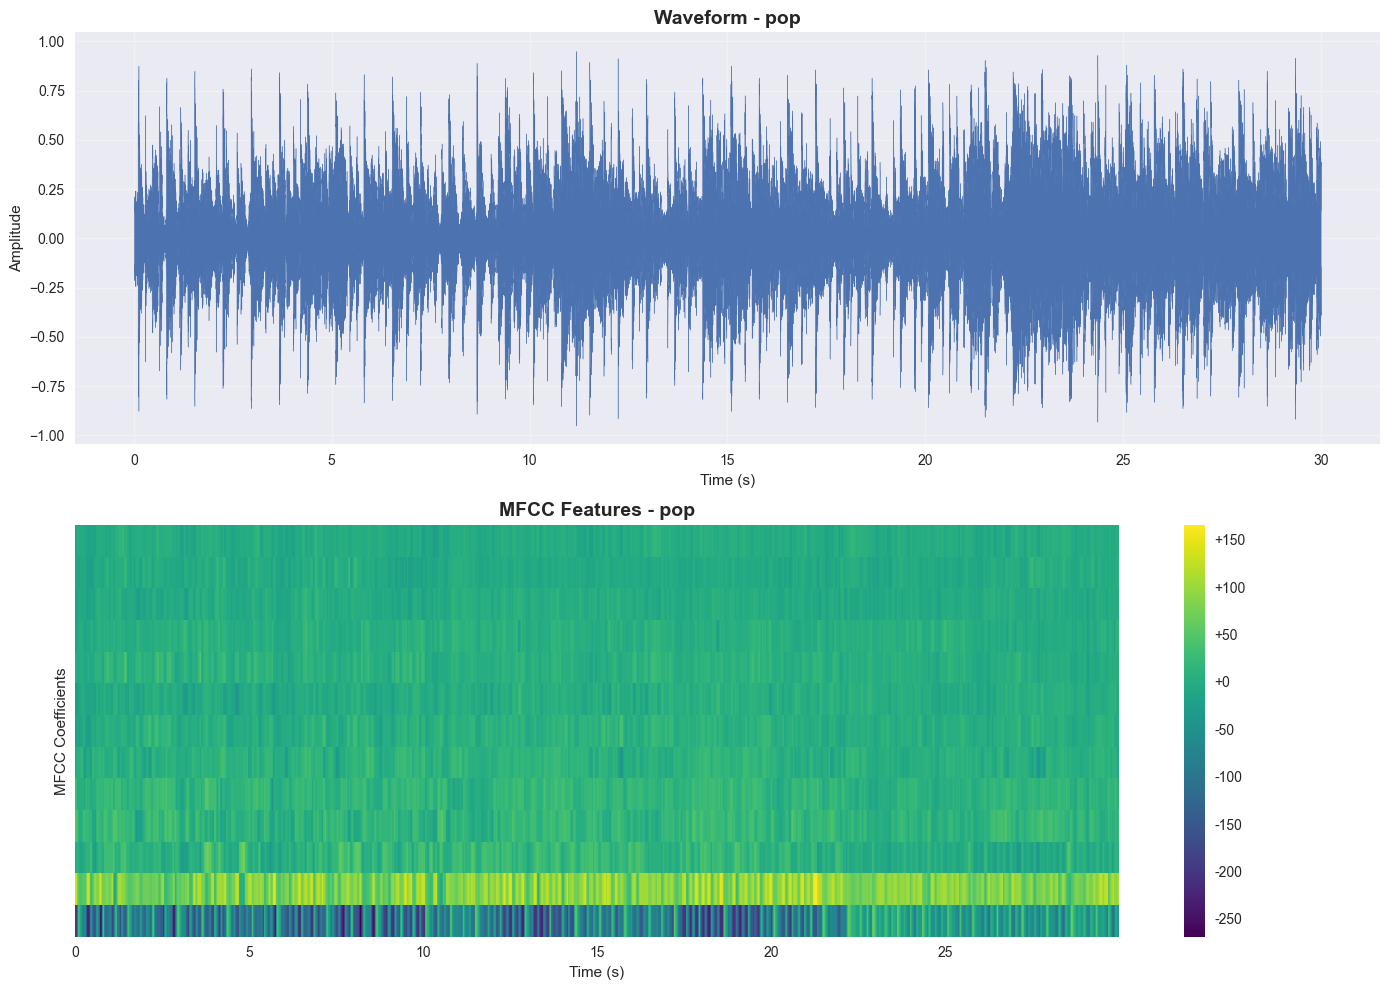

Aggregated feature vector shape: (26,)
First 10 features (mean of first 10 MFCCs): [-75.36613    83.334885   10.703896   14.455102   14.244521    7.4102573
   5.279713   -0.4001256   5.7177567   3.3618035]


In [ ]:
def visualize_mfcc(file_path, genre):
    """
    Visualize MFCC features for a sample audio file.
    """
    # Load audio
    y, sr = librosa.load(file_path, sr=SAMPLING_RATE, duration=DURATION)
    
    # Extract MFCCs
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC)
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    # Plot waveform
    librosa.display.waveshow(y, sr=sr, ax=axes[0])
    axes[0].set_title(f'Waveform - {genre}', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Time (s)')
    axes[0].set_ylabel('Amplitude')
    axes[0].grid(True, alpha=0.3)
    
    # Plot MFCCs
    img = librosa.display.specshow(mfcc, x_axis='time', ax=axes[1], cmap='viridis')
    axes[1].set_title(f'MFCC Features - {genre}', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('MFCC Coefficients')
    axes[1].set_xlabel('Time (s)')
    fig.colorbar(img, ax=axes[1], format='%+2.0f')
    
    plt.tight_layout()
    plt.show()
    
    # Print aggregated features
    features = aggregate_mfcc_features(mfcc)
    print(f"Aggregated feature vector shape: {features.shape}")
    print(f"First 10 features (mean of first 10 MFCCs): {features[:10]}")

# Visualize sample MFCC
sample_file = audio_files[0][0]
sample_genre = audio_files[0][1]
visualize_mfcc(sample_file, sample_genre)

### Part D: Exploratory Data Analysis

Analyze the dataset distribution and feature characteristics.

Dataset Summary:
Total samples: 999

Genre distribution:
genre
blues        100
classical    100
country      100
disco        100
hiphop       100
jazz          99
metal        100
pop          100
reggae       100
rock         100
Name: count, dtype: int64

Feature statistics:
               0           1           2           3           4           5   \
count  999.000000  999.000000  999.000000  999.000000  999.000000  999.000000   
mean  -144.529709   99.529892   -8.930675   36.307606   -1.154265   14.644125   
std    100.274376   31.334740   21.702665   16.668253   12.227953   11.844153   
min   -552.106323   -1.539154  -89.896149  -18.786009  -38.915707  -28.421492   
25%   -200.849762   76.792130  -24.230801   24.135523   -9.993215    5.086104   
50%   -120.324814   98.399033  -10.732934   36.979443   -0.045610   15.036698   
75%    -73.791946  119.732929    5.539077   48.259081    7.909429   23.859729   
max     42.112869  193.094482   56.636234   80.692482   31.457941   45.1

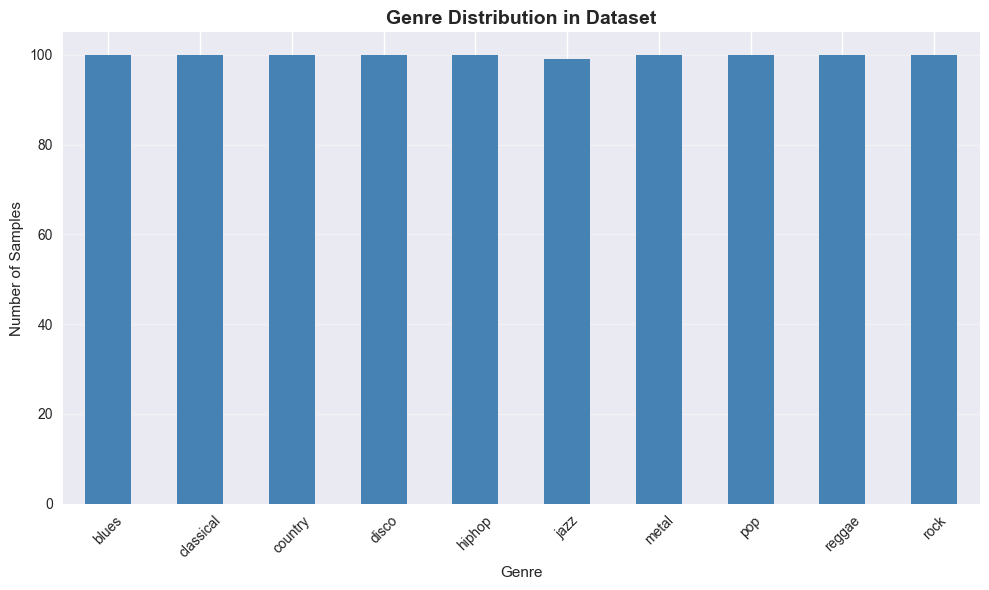

In [ ]:
# Create DataFrame for analysis
df = pd.DataFrame(X)
df['genre'] = y

print("Dataset Summary:")
print(f"Total samples: {len(df)}")
print(f"\nGenre distribution:")
print(df['genre'].value_counts().sort_index())
print(f"\nFeature statistics:")
print(df.drop('genre', axis=1).describe())

# Visualize genre distribution
plt.figure(figsize=(10, 6))
df['genre'].value_counts().sort_index().plot(kind='bar', color='steelblue')
plt.title('Genre Distribution in Dataset', fontsize=14, fontweight='bold')
plt.xlabel('Genre')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### Part E: Data Preprocessing and Train/Test Split

Encode labels, standardize features, and split into training and test sets.

In [ ]:
# Encode genre labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(f"Label encoding:")
for i, genre in enumerate(label_encoder.classes_):
    print(f"  {genre}: {i}")

# Split dataset (80% train, 20% test) with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_encoded
)

print(f"\nDataset split:")
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nFeature standardization complete!")
print(f"Training mean: {X_train_scaled.mean():.6f}")
print(f"Training std: {X_train_scaled.std():.6f}")

Label encoding:
  blues: 0
  classical: 1
  country: 2
  disco: 3
  hiphop: 4
  jazz: 5
  metal: 6
  pop: 7
  reggae: 8
  rock: 9

Dataset split:
Training samples: 799
Test samples: 200
Training set shape: (799, 26)
Test set shape: (200, 26)

Feature standardization complete!
Training mean: 0.000000
Training std: 1.000000


---

## 8. Model Training and Evaluation

### Part A: Baseline Model Training

Train four baseline classifiers with default parameters.

In [ ]:
def train_baseline_models(X_train, y_train):
    """
    Train baseline models with default parameters.
    
    Returns:
    --------
    models : dict
        Dictionary of trained models
    """
    models = {
        'KNN': KNeighborsClassifier(),
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'Random Forest': RandomForestClassifier(random_state=42),
        'SVM': SVC(random_state=42)
    }
    
    print("Training baseline models...\n")
    
    for name, model in models.items():
        print(f"Training {name}...")
        model.fit(X_train, y_train)
        print(f"  ✓ {name} training complete")
    
    print("\nAll baseline models trained successfully!")
    return models


def evaluate_model(model, X_test, y_test, model_name):
    """
    Evaluate a trained model and print performance metrics.
    """
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    
    print(f"\n{'='*50}")
    print(f"{model_name} Performance")
    print(f"{'='*50}")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'predictions': y_pred
    }

# Train baseline models
baseline_models = train_baseline_models(X_train_scaled, y_train)

Training baseline models...

Training KNN...
  ✓ KNN training complete
Training Decision Tree...
  ✓ Decision Tree training complete
Training Random Forest...
  ✓ Random Forest training complete
Training SVM...
  ✓ SVM training complete

All baseline models trained successfully!
  ✓ Random Forest training complete
Training SVM...
  ✓ SVM training complete

All baseline models trained successfully!


### Part B: Evaluate Baseline Models

Evaluate all baseline models on the test set.


KNN Performance
Accuracy:  0.6450
Precision: 0.6554
Recall:    0.6450
F1-Score:  0.6430

Decision Tree Performance
Accuracy:  0.4950
Precision: 0.5139
Recall:    0.4950
F1-Score:  0.5007

Random Forest Performance
Accuracy:  0.6500
Precision: 0.6494
Recall:    0.6500
F1-Score:  0.6459

SVM Performance
Accuracy:  0.6800
Precision: 0.6786
Recall:    0.6800
F1-Score:  0.6749

BASELINE MODEL COMPARISON
              accuracy precision recall  f1_score
KNN              0.645  0.655368  0.645  0.643048
Decision Tree    0.495   0.51389  0.495  0.500685
Random Forest     0.65  0.649399   0.65  0.645872
SVM               0.68   0.67862   0.68  0.674886


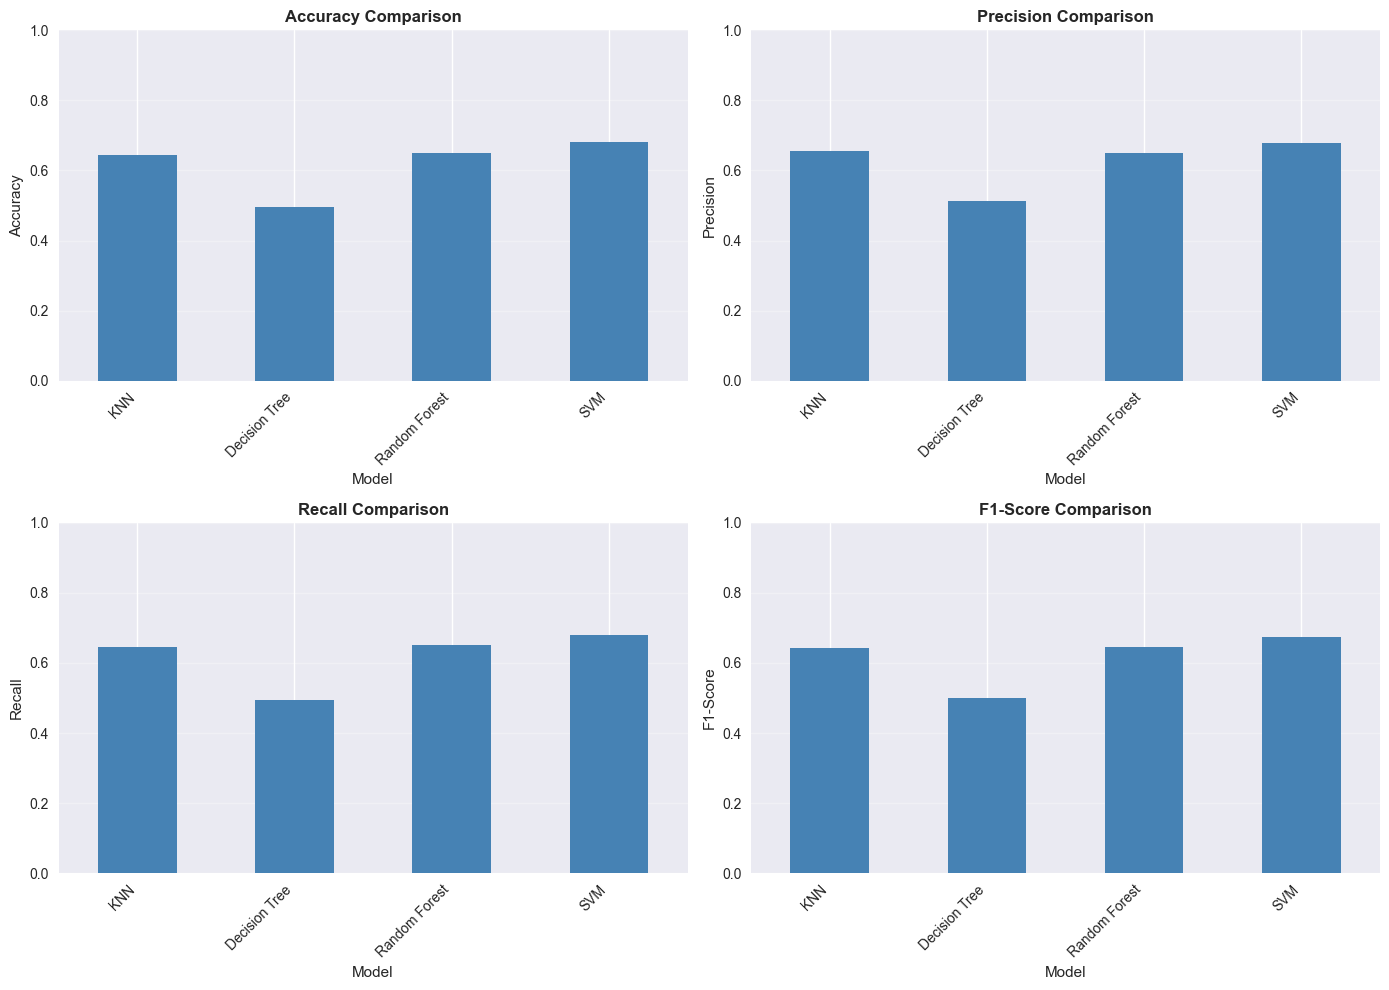

In [ ]:
# Evaluate all baseline models
results = {}
for name, model in baseline_models.items():
    results[name] = evaluate_model(model, X_test_scaled, y_test, name)

# Create results DataFrame for comparison
results_df = pd.DataFrame(results).T
results_df = results_df.drop('predictions', axis=1)

print("\n" + "="*70)
print("BASELINE MODEL COMPARISON")
print("="*70)
print(results_df.round(4))

# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
metrics = ['accuracy', 'precision', 'recall', 'f1_score']
titles = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

for idx, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[idx // 2, idx % 2]
    results_df[metric].plot(kind='bar', ax=ax, color='steelblue')
    ax.set_title(f'{title} Comparison', fontsize=12, fontweight='bold')
    ax.set_ylabel(title)
    ax.set_xlabel('Model')
    ax.set_ylim([0, 1])
    ax.grid(axis='y', alpha=0.3)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

### Part C: Hyperparameter Tuning

Optimize model hyperparameters using GridSearchCV.

In [ ]:
def hyperparameter_tuning(X_train, y_train):
    """
    Perform hyperparameter tuning for each model using GridSearchCV.
    
    Returns:
    --------
    tuned_models : dict
        Dictionary of tuned models with best parameters
    """
    # Define parameter grids for each model (reduced for faster runtime)
    param_grids = {
        'KNN': {
            'n_neighbors': [3, 5, 7],
            'weights': ['uniform', 'distance']
        },
        'Decision Tree': {
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5]
        },
        'Random Forest': {
            'n_estimators': [50, 100],
            'max_depth': [10, 20],
            'min_samples_split': [2, 5]
        },
        'SVM': {
            'C': [0.1, 1, 10],
            'kernel': ['rbf', 'linear']
        }
    }
    
    base_models = {
        'KNN': KNeighborsClassifier(),
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'Random Forest': RandomForestClassifier(random_state=42),
        'SVM': SVC(random_state=42)
    }
    
    tuned_models = {}
    best_params = {}
    
    print("Performing hyperparameter tuning...\n")
    
    for name in base_models.keys():
        print(f"Tuning {name}...")
        grid_search = GridSearchCV(
            base_models[name],
            param_grids[name],
            cv=3,  # Reduced from 5 to 3 for faster runtime
            scoring='accuracy',
            n_jobs=-1,
            verbose=0
        )
        
        grid_search.fit(X_train, y_train)
        tuned_models[name] = grid_search.best_estimator_
        best_params[name] = grid_search.best_params_
        
        print(f"  ✓ Best parameters: {grid_search.best_params_}")
        print(f"  ✓ Best CV score: {grid_search.best_score_:.4f}\n")
    
    print("Hyperparameter tuning complete!")
    return tuned_models, best_params

# Perform hyperparameter tuning
tuned_models, best_params = hyperparameter_tuning(X_train_scaled, y_train)

Performing hyperparameter tuning...

Tuning KNN...
  ✓ Best parameters: {'n_neighbors': 5, 'weights': 'distance'}
  ✓ Best CV score: 0.6195

Tuning Decision Tree...
  ✓ Best parameters: {'max_depth': 20, 'min_samples_split': 2}
  ✓ Best CV score: 0.4418

Tuning Random Forest...
  ✓ Best parameters: {'n_neighbors': 5, 'weights': 'distance'}
  ✓ Best CV score: 0.6195

Tuning Decision Tree...
  ✓ Best parameters: {'max_depth': 20, 'min_samples_split': 2}
  ✓ Best CV score: 0.4418

Tuning Random Forest...
  ✓ Best parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}
  ✓ Best CV score: 0.6245

Tuning SVM...
  ✓ Best parameters: {'C': 10, 'kernel': 'rbf'}
  ✓ Best CV score: 0.6846

Hyperparameter tuning complete!
  ✓ Best parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}
  ✓ Best CV score: 0.6245

Tuning SVM...
  ✓ Best parameters: {'C': 10, 'kernel': 'rbf'}
  ✓ Best CV score: 0.6846

Hyperparameter tuning complete!


### Part D: Evaluate Tuned Models

Evaluate the tuned models on the test set and compare with baseline performance.


KNN (Tuned) Performance
Accuracy:  0.6250
Precision: 0.6420
Recall:    0.6250
F1-Score:  0.6273

Decision Tree (Tuned) Performance
Accuracy:  0.4950
Precision: 0.5139
Recall:    0.4950
F1-Score:  0.5007

Random Forest (Tuned) Performance
Accuracy:  0.6500
Precision: 0.6494
Recall:    0.6500
F1-Score:  0.6459

SVM (Tuned) Performance
Accuracy:  0.7000
Precision: 0.7032
Recall:    0.7000
F1-Score:  0.7001

TUNED MODEL COMPARISON
              accuracy precision recall  f1_score
KNN              0.625   0.64198  0.625  0.627331
Decision Tree    0.495   0.51389  0.495  0.500685
Random Forest     0.65  0.649399   0.65  0.645872
SVM                0.7  0.703242    0.7  0.700122

BASELINE VS TUNED COMPARISON
              Baseline Accuracy Tuned Accuracy Improvement
KNN                       0.645          0.625       -0.02
Decision Tree             0.495          0.495         0.0
Random Forest              0.65           0.65         0.0
SVM                        0.68            0.7      

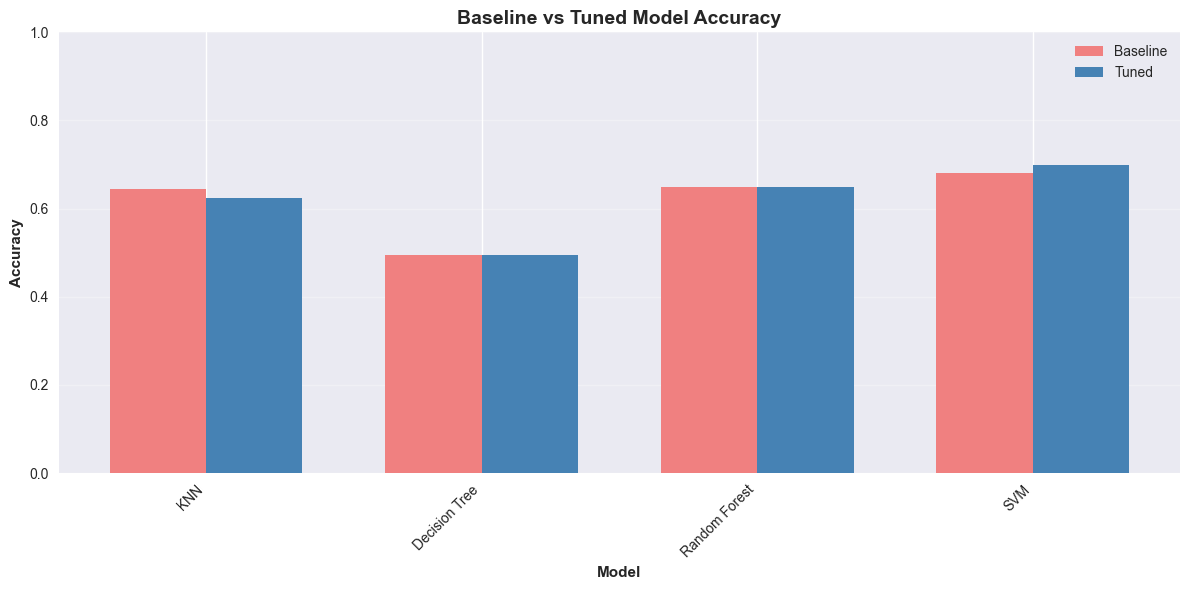

In [ ]:
# Evaluate tuned models
tuned_results = {}
for name, model in tuned_models.items():
    tuned_results[name] = evaluate_model(model, X_test_scaled, y_test, f"{name} (Tuned)")

# Create comparison DataFrame
tuned_results_df = pd.DataFrame(tuned_results).T
tuned_results_df = tuned_results_df.drop('predictions', axis=1)

print("\n" + "="*70)
print("TUNED MODEL COMPARISON")
print("="*70)
print(tuned_results_df.round(4))

# Compare baseline vs tuned
comparison_df = pd.DataFrame({
    'Baseline Accuracy': results_df['accuracy'],
    'Tuned Accuracy': tuned_results_df['accuracy'],
    'Improvement': tuned_results_df['accuracy'] - results_df['accuracy']
})

print("\n" + "="*70)
print("BASELINE VS TUNED COMPARISON")
print("="*70)
print(comparison_df.round(4))

# Visualize improvement
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(comparison_df))
width = 0.35

ax.bar(x - width/2, comparison_df['Baseline Accuracy'], width, label='Baseline', color='lightcoral')
ax.bar(x + width/2, comparison_df['Tuned Accuracy'], width, label='Tuned', color='steelblue')

ax.set_xlabel('Model', fontweight='bold')
ax.set_ylabel('Accuracy', fontweight='bold')
ax.set_title('Baseline vs Tuned Model Accuracy', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df.index, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1])

plt.tight_layout()
plt.show()

### Part E: Confusion Matrix Analysis

Generate and visualize confusion matrices for the best performing models.

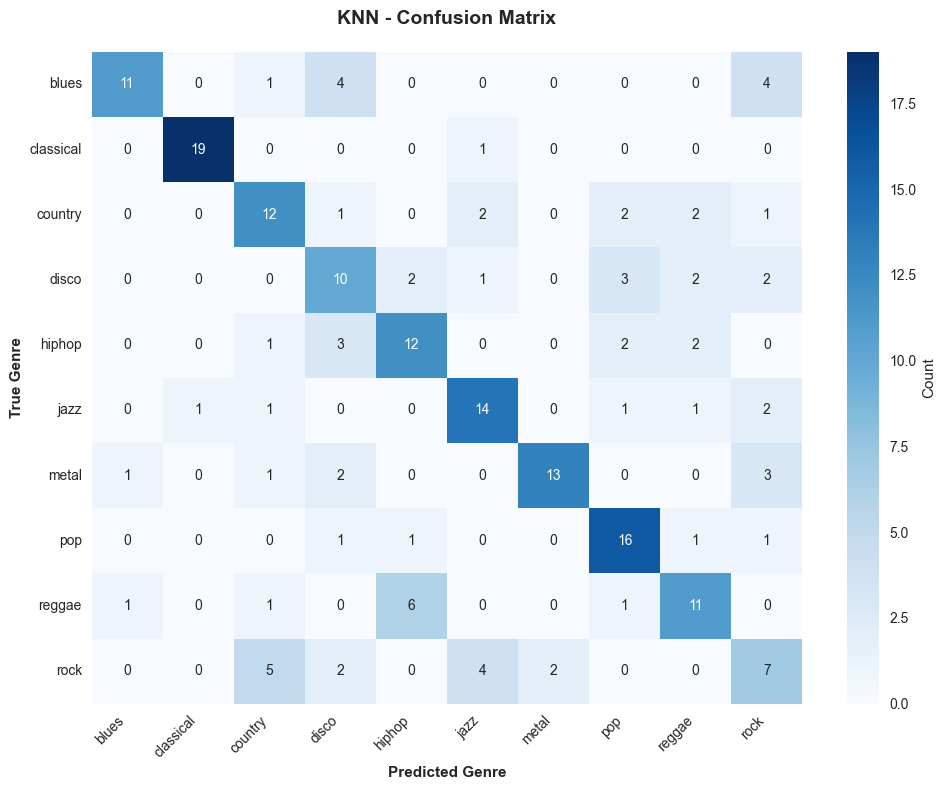


Confusion Matrix Statistics for KNN - Confusion Matrix:
Total predictions: 200
Correct predictions: 125 (62.50%)
Incorrect predictions: 75 (37.50%)

Most Common Misclassifications:
  reggae → hiphop: 6 times
  rock → country: 5 times
  rock → jazz: 4 times
  blues → disco: 4 times
  blues → rock: 4 times


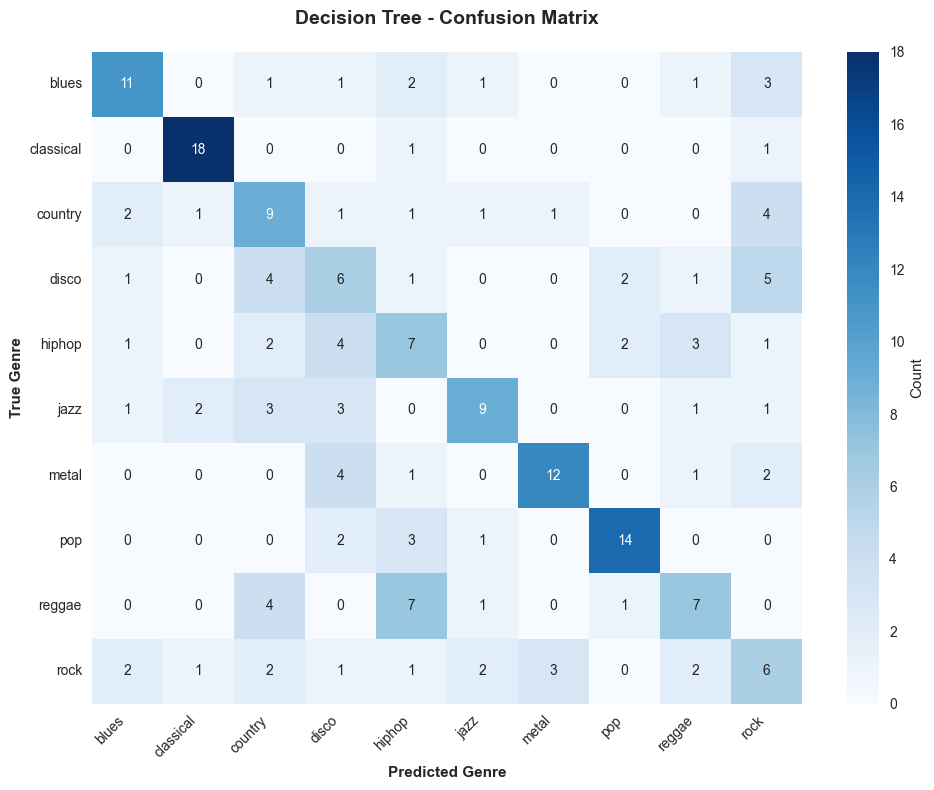


Confusion Matrix Statistics for Decision Tree - Confusion Matrix:
Total predictions: 200
Correct predictions: 99 (49.50%)
Incorrect predictions: 101 (50.50%)

Most Common Misclassifications:
  reggae → hiphop: 7 times
  disco → rock: 5 times
  hiphop → disco: 4 times
  country → rock: 4 times
  reggae → country: 4 times


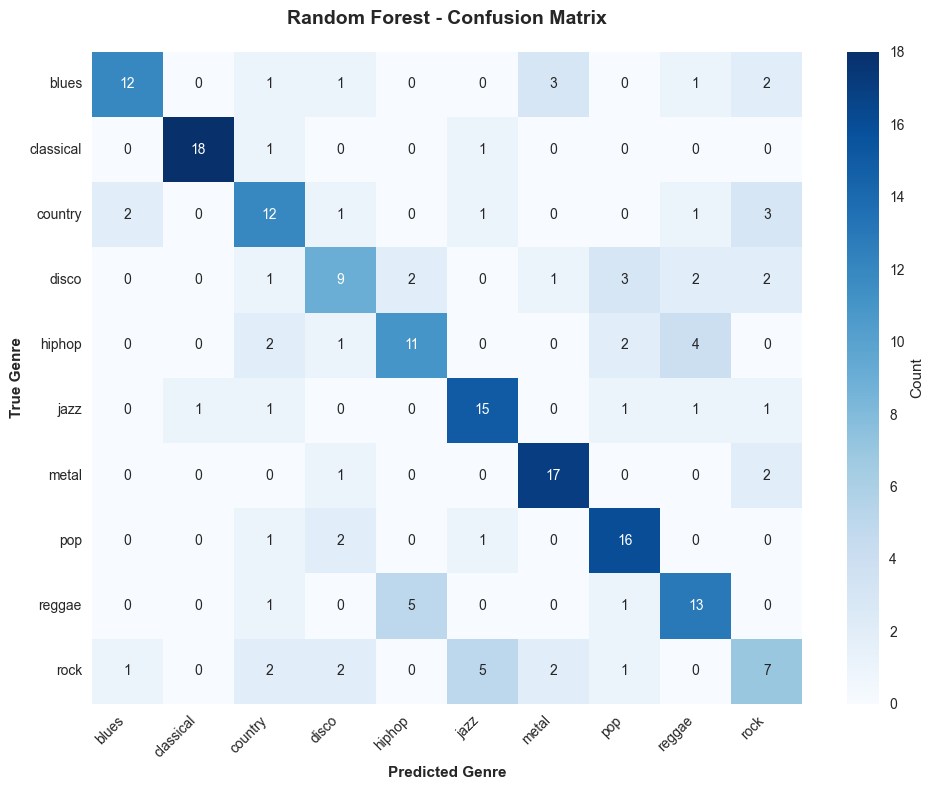


Confusion Matrix Statistics for Random Forest - Confusion Matrix:
Total predictions: 200
Correct predictions: 130 (65.00%)
Incorrect predictions: 70 (35.00%)

Most Common Misclassifications:
  rock → jazz: 5 times
  reggae → hiphop: 5 times
  hiphop → reggae: 4 times
  disco → pop: 3 times
  blues → metal: 3 times


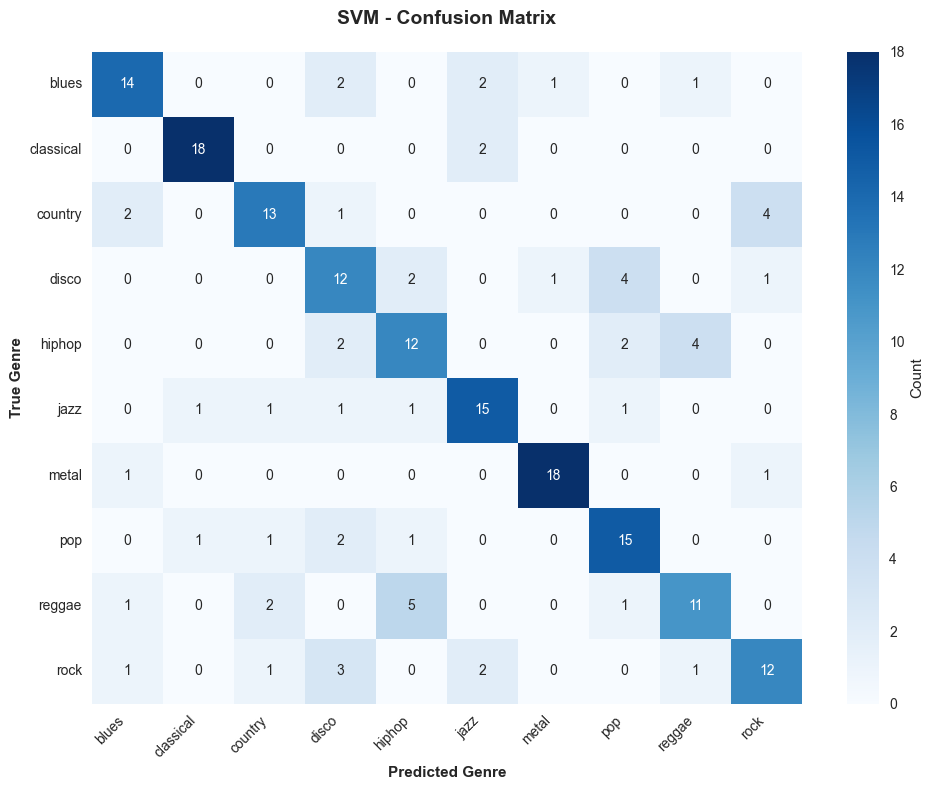


Confusion Matrix Statistics for SVM - Confusion Matrix:
Total predictions: 200
Correct predictions: 140 (70.00%)
Incorrect predictions: 60 (30.00%)

Most Common Misclassifications:
  reggae → hiphop: 5 times
  hiphop → reggae: 4 times
  country → rock: 4 times
  disco → pop: 4 times
  rock → disco: 3 times


In [ ]:
def plot_confusion_matrix(y_true, y_pred, labels, title):
    """
    Plot confusion matrix with custom styling.
    """
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=labels, yticklabels=labels,
                cbar_kws={'label': 'Count'})
    plt.title(title, fontsize=14, fontweight='bold', pad=20)
    plt.ylabel('True Genre', fontweight='bold')
    plt.xlabel('Predicted Genre', fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Calculate and display misclassification statistics
    total = cm.sum()
    correct = np.trace(cm)
    incorrect = total - correct
    
    print(f"\nConfusion Matrix Statistics for {title}:")
    print(f"Total predictions: {total}")
    print(f"Correct predictions: {correct} ({correct/total*100:.2f}%)")
    print(f"Incorrect predictions: {incorrect} ({incorrect/total*100:.2f}%)")
    
    # Find most confused genre pairs
    print("\nMost Common Misclassifications:")
    cm_off_diagonal = cm.copy()
    np.fill_diagonal(cm_off_diagonal, 0)
    
    # Get top 5 misclassifications
    flat_indices = np.argsort(cm_off_diagonal.ravel())[::-1][:5]
    for idx in flat_indices:
        i, j = np.unravel_index(idx, cm_off_diagonal.shape)
        count = cm_off_diagonal[i, j]
        if count > 0:
            print(f"  {labels[i]} → {labels[j]}: {count} times")


# Plot confusion matrices for all tuned models
genre_labels = label_encoder.classes_

for name, result in tuned_results.items():
    y_pred = result['predictions']
    plot_confusion_matrix(y_test, y_pred, genre_labels, f'{name} - Confusion Matrix')

### Part F: Detailed Classification Report

Generate detailed classification reports showing per-genre performance.

DETAILED CLASSIFICATION REPORT - SVM
              precision    recall  f1-score   support

       blues       0.74      0.70      0.72        20
   classical       0.90      0.90      0.90        20
     country       0.72      0.65      0.68        20
       disco       0.52      0.60      0.56        20
      hiphop       0.57      0.60      0.59        20
        jazz       0.71      0.75      0.73        20
       metal       0.90      0.90      0.90        20
         pop       0.65      0.75      0.70        20
      reggae       0.65      0.55      0.59        20
        rock       0.67      0.60      0.63        20

    accuracy                           0.70       200
   macro avg       0.70      0.70      0.70       200
weighted avg       0.70      0.70      0.70       200



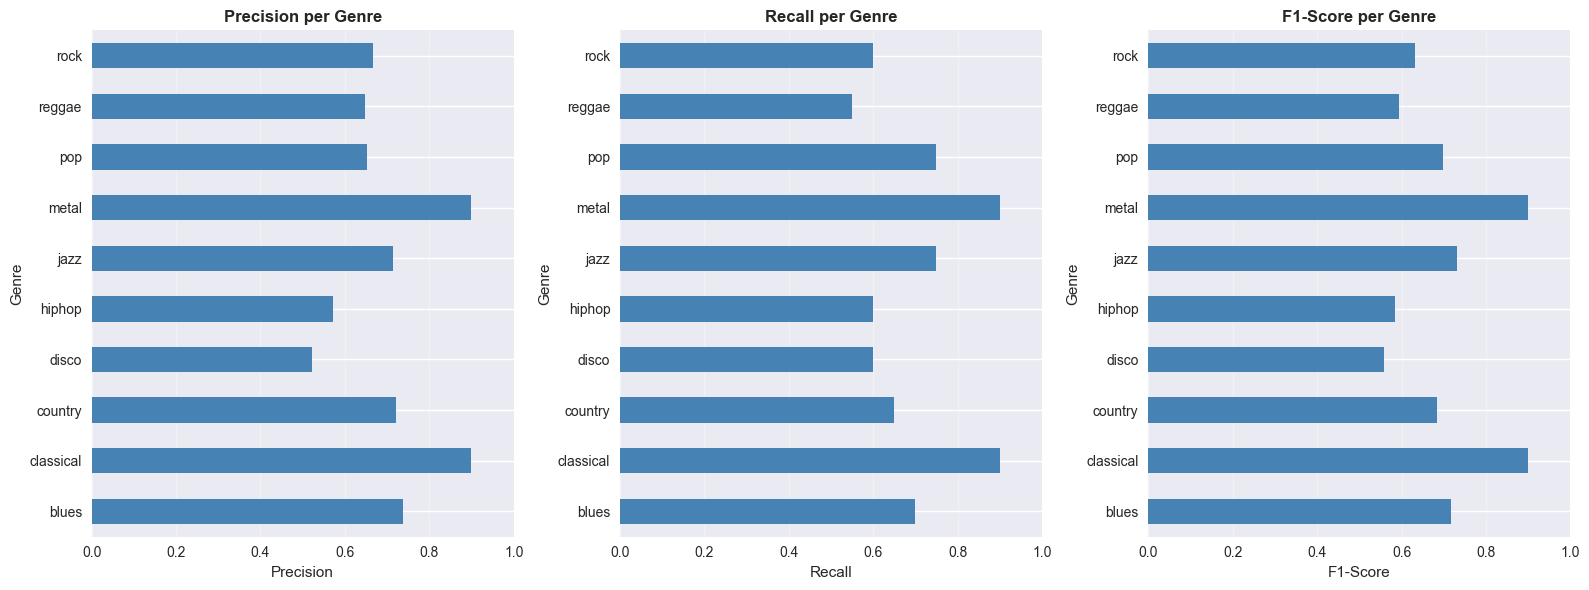

In [ ]:
# Generate classification reports for best model
# Find best model based on accuracy
best_model_name = tuned_results_df['accuracy'].idxmax()
best_model = tuned_models[best_model_name]
best_predictions = tuned_results[best_model_name]['predictions']

print("="*70)
print(f"DETAILED CLASSIFICATION REPORT - {best_model_name}")
print("="*70)
print(classification_report(y_test, best_predictions, target_names=genre_labels))

# Visualize per-genre performance
report_dict = classification_report(y_test, best_predictions, target_names=genre_labels, output_dict=True)
report_df = pd.DataFrame(report_dict).T[:-3]  # Exclude accuracy, macro avg, weighted avg

fig, axes = plt.subplots(1, 3, figsize=(16, 6))

for idx, metric in enumerate(['precision', 'recall', 'f1-score']):
    report_df[metric].plot(kind='barh', ax=axes[idx], color='steelblue')
    axes[idx].set_title(f'{metric.title()} per Genre', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(metric.title())
    axes[idx].set_ylabel('Genre')
    axes[idx].set_xlim([0, 1])
    axes[idx].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()